In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import my_functions as myf
import sklearn

define audiofile

In [3]:
filename='./prueba30seg.wav'

Handle audio file

In [4]:
fs, audio_i = wavfile.read(filename)
audio=audio_i[:,0]
time=np.arange(len(audio))* 1/float(fs)
nsamp=len(audio)

In [5]:
print('sampling frequency: {}Hz'.format(fs))
print('total time: {}s'.format(time[-1]))
print('audio shape:{}'.format(audio.shape))

sampling frequency: 44100Hz
total time: 29.99997732426304s
audio shape:(1323000,)


VAD

In [31]:
from vad import VoiceActivityDetector

In [32]:
vad = VoiceActivityDetector(filename)

In [36]:
energy = vad._calculate_energy(vad.data)

In [40]:
vad.data.shape

(1323000,)

In [38]:
energy.shape

(1322999,)

<IPython.core.display.Javascript object>


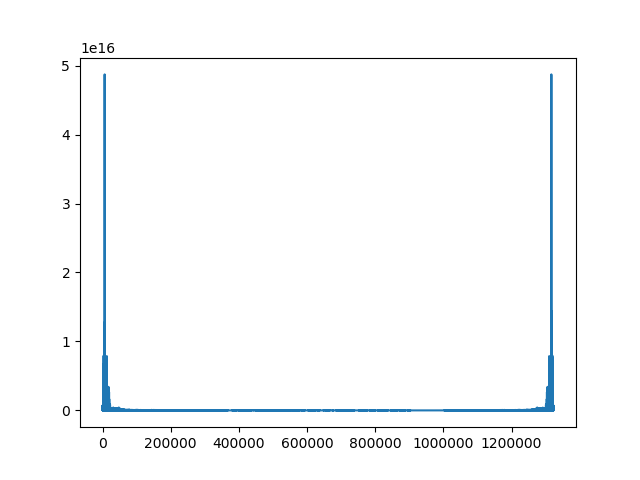

In [41]:
plt.figure()
plt.plot(energy)

<IPython.core.display.Javascript object>


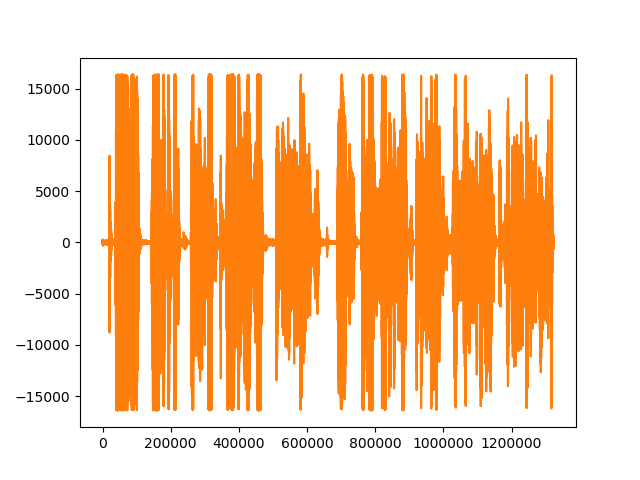

In [33]:
vad.plot_detected_speech_regions()

In [42]:
windows = vad.detect_speech()

In [48]:
windows[-1][0]

1321677.0

In [54]:
w_size = np.unique(np.diff(windows[:,0]))

In [58]:
 vad.data

array([  0,   0,   0, ..., 168, 182, 195], dtype=int16)

<IPython.core.display.Javascript object>


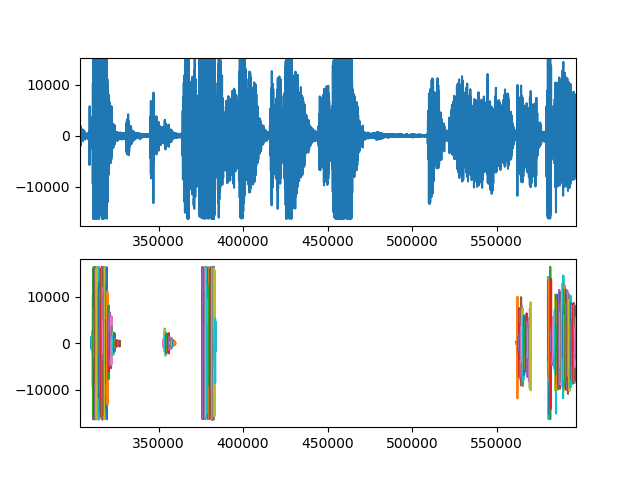

In [62]:
plt.figure()
ax1 = plt.subplot(2,1,1)
plt.plot(vad.data)

plt.subplot(2,1,2, sharex=ax1) 
for i,v in enumerate(windows[:,0]):
    int_ini = int(v)
    int_end = int(v+w_size)
    if windows[i,1]==1:
        plt.plot(range(int_ini,int_end), vad.data[int_ini: int_end])

librosa RMS energy --> desibeles, humbral

In [5]:
import librosa

In [210]:
22050
661500

22050

In [237]:
audio, sr= librosa.load(filename, sr =22050/4 )
print(audio.shape)

(165375,)


<IPython.core.display.Javascript object>


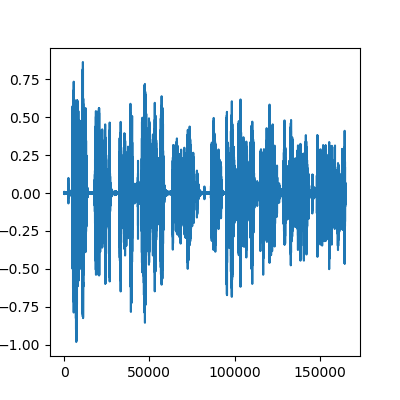

In [238]:
plt.figure(figsize = (4,4))
plt.plot(audio)

https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html

https://github.com/librosa/librosa/issues/463

In [240]:
n_fft = 128
fourier = librosa.stft(audio, n_fft=n_fft)
S = fourier**2
log_S = librosa.perceptual_weighting(S**2, librosa.fft_frequencies(n_fft=n_fft))
loudness = log_S.sum(axis=0, keepdims=True)
#db = librosa.core.power_to_db(loudness)
print(loudness.shape)

(1, 5168)


In [380]:
loud0 = loudness[0]

<IPython.core.display.Javascript object>


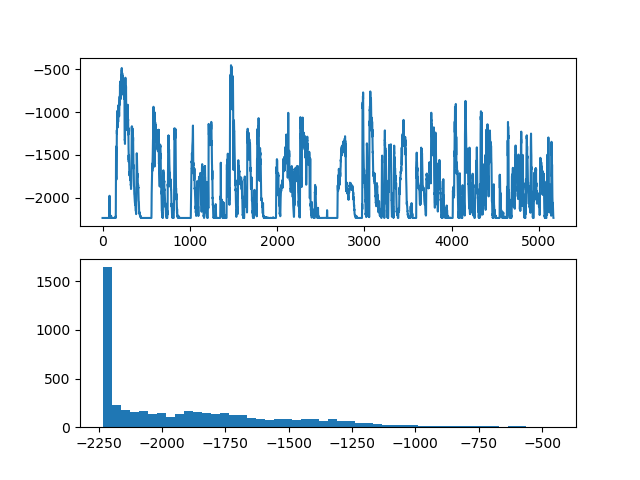

(array([1643.,  223.,  175.,  153.,  168.,  138.,  142.,  107.,  138.,
         165.,  151.,  148.,  139.,  144.,  126.,  121.,   90.,   81.,
          73.,   88.,   88.,   75.,   81.,   81.,   63.,   84.,   66.,
          65.,   48.,   40.,   29.,   27.,   23.,   18.,   22.,   14.,
          13.,   12.,   11.,   13.,    9.,   16.,   10.,    9.,    5.,
          13.,   11.,    3.,    3.,    3.]),
 array([-2234.40982383, -2198.81767707, -2163.2255303 , -2127.63338353,
        -2092.04123676, -2056.44908999, -2020.85694322, -1985.26479645,
        -1949.67264969, -1914.08050292, -1878.48835615, -1842.89620938,
        -1807.30406261, -1771.71191584, -1736.11976907, -1700.52762231,
        -1664.93547554, -1629.34332877, -1593.751182  , -1558.15903523,
        -1522.56688846, -1486.97474169, -1451.38259493, -1415.79044816,
        -1380.19830139, -1344.60615462, -1309.01400785, -1273.42186108,
        -1237.82971431, -1202.23756755, -1166.64542078, -1131.05327401,
        -1095.46112724, 

In [379]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(loudness[0])
plt.subplot(2,1,2)
plt.hist(loudness[0], bins=50)

<IPython.core.display.Javascript object>


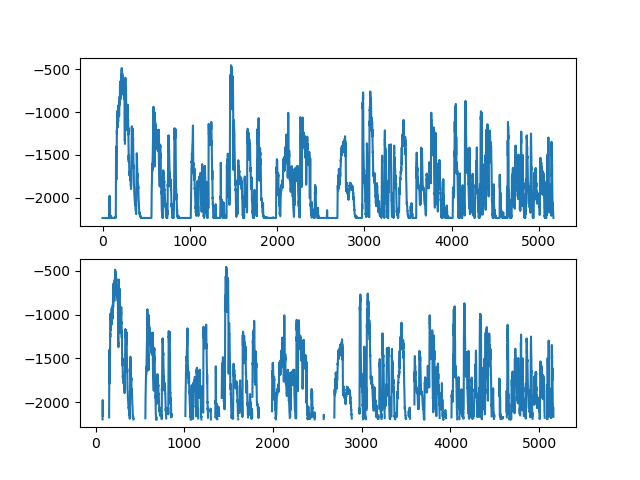

In [388]:
frac = 50.
tresh_ = (np.max(loud0)-np.min(loud0))/frac
tresh = np.min(loud0)+tresh_
filter_tresh = loud0>tresh
plt.figure()
ax1 =plt.subplot(2,1,1)
plt.plot(loud0)
plt.subplot(2,1,2)
loudf = np.copy(loud0)
loudf[~filter_tresh] = np.nan
plt.plot(loudf)

In [336]:
norm = S.sum(axis = 0)
S_normed = S/norm
print(S_normed.shape)
pse = np.array([-np.sum(S_normed[:,i]*np.log(S_normed[:,i])) for i in range(np.shape(S_normed)[1])])

(65, 5168)


<IPython.core.display.Javascript object>


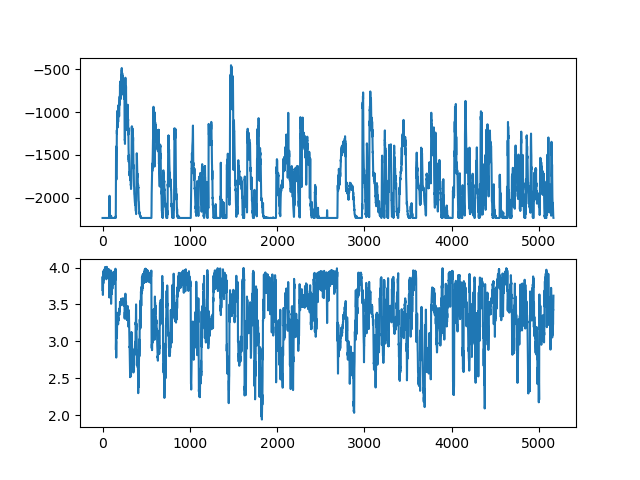

In [339]:
plt.figure()
ax1 = plt.subplot(2,1,1)
plt.plot(loudness[0])
plt.subplot(2,1,2, sharex= ax1)
plt.plot(pse)

spectrogram

In [242]:
S, phase = librosa.magphase(librosa.stft(y=audio, n_fft=n_fft))
print(S.shape)

(65, 5168)


<IPython.core.display.Javascript object>


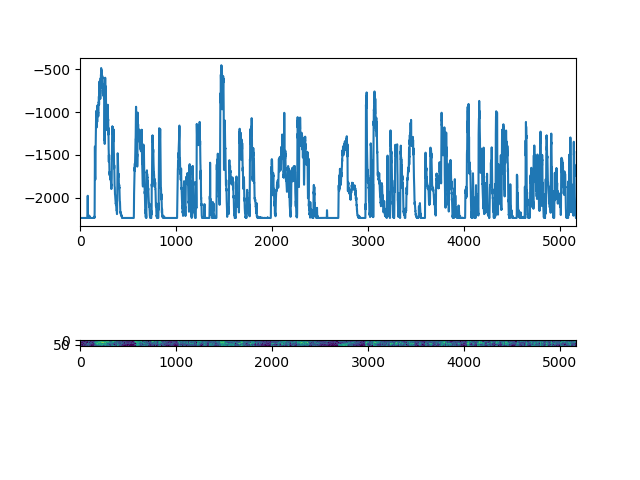

In [243]:
plt.figure()
ax1 = plt.subplot(2,1,1)
plt.plot(loudness[0])
plt.subplot(2,1,2, sharex=ax1)
spec = librosa.amplitude_to_db(S, ref=np.max)
plt.imshow(spec)                  

In [345]:
features = np.vstack((S, loudness, pse))

In [346]:
features.shape

(67, 5168)

In [347]:
import sklearn

In [348]:
norm_features = sklearn.preprocessing.normalize(features.T)
print(norm_features.shape)

(5168, 67)


In [364]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3)
data = tsne.fit_transform(norm_features)
data.shape

In [366]:
from sklearn.decomposition import PCA
data_2 = PCA(n_components=5).fit_transform(norm_features)
data_2.shape

(5168, 5)

<IPython.core.display.Javascript object>


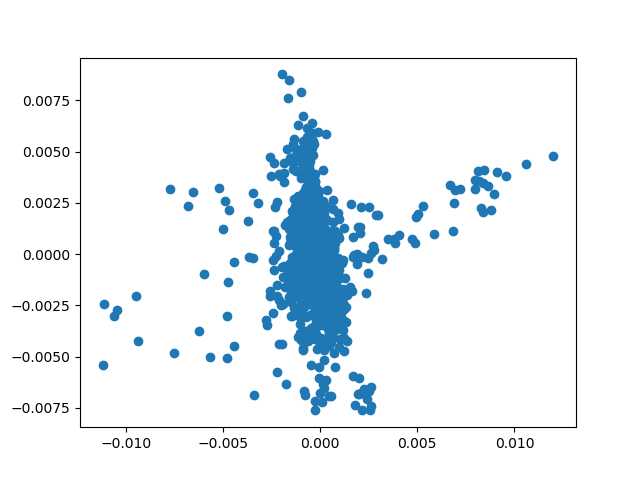

In [353]:
plt.figure()
plt.plot(data[:,3], data[:,2],'o')

<IPython.core.display.Javascript object>


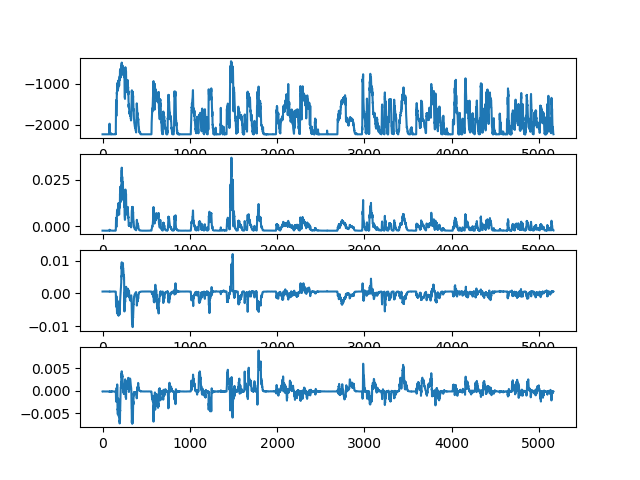

In [296]:
plt.figure()
ax1 = plt.subplot(4,1,1)
plt.plot(loudness[0])
plt.subplot(4,1,2, sharex = ax1)
plt.plot(data[:,0])
plt.subplot(4,1,3, sharex = ax1)
plt.plot(data[:,1])
plt.subplot(4,1,4, sharex = ax1)
plt.plot(data[:,2])

In [367]:
normed_loud = sklearn.preprocessing.normalize(loudness.T)

In [368]:
normed_loud.shape

(5168, 1)

In [356]:
data.shape

(5168, 5)

In [375]:
features2 = np.concatenate((data, data_2, normed_loud), axis=1)
print(features2.shape)

(5168, 9)


In [374]:
from sklearn.cluster import KMeans, SpectralClustering

In [371]:
kmeans = KMeans(n_clusters = 2)
groups = kmeans.fit_predict(features2)

In [376]:
cluster_algo = SpectralClustering(n_clusters = 2)
groups = cluster_algo.fit_predict(features2)

<IPython.core.display.Javascript object>


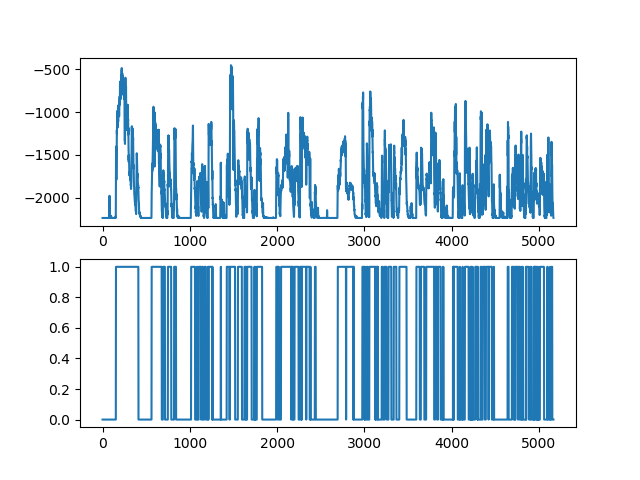

In [377]:
plt.figure()
ax1 = plt.subplot(2,1,1)
plt.plot(loudness[0])
plt.subplot(2,1,2, sharex = ax1)
plt.plot(groups)

energies

In [ ]:
window_size = 512
energy = librosa.feature.rmse(audio[0], frame_length= 2048, hop_length=window_size)

In [50]:
n_energies = len(energy[0])
print(n_energies)

1292


In [51]:
energy[0].shape

(1292,)

<IPython.core.display.Javascript object>


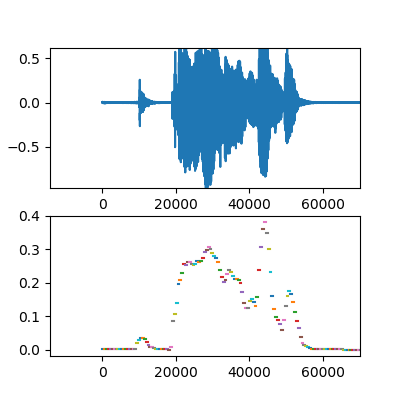

In [52]:
plt.figure(figsize = (4,4))
ax1 = plt.subplot(2,1,1)
plt.plot(audio[0])
plt.subplot(2,1,2, sharex=ax1)
for i in range(n_energies):
    interval = i*window_size+np.arange(window_size)
    plt.plot(interval, np.ones(window_size)*energy[0][i])

In [ ]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

In [ ]:
n_points = 200
audio_rs = audio[::n_points]
n_max = int(np.floor(len(audio)/n_points))
autocors = []
for i in range(0,len(audio),n_points):
    autocors.append(autocorr(audio[i:i+n_points]))
autocors = np.array(autocors)    
print(autocors.shape)

In [ ]:
plt.figure()
plt.plot(autocorr(autocors[3350]))
plt.plot(autocorr(autocors[4000]))

In [ ]:
plt.figure()
plt.plot(audio_rs)

In [ ]:
spectrum_fourier=myf.stft(audio, fftsize=512)
n1=spectrum_size=np.size(s1,0)
amplitude=np.mean(np.real(s1*np.conjugate(s1)),1)
t1=np.arange(n1)/float(n1)*time[-1]
samp2=len(audio)/float(len(t1))
a1=np.interp(t1, time, audio)

In [ ]:
spectrum_fourier.shape

In [ ]:
plt.figure()
i=600; plt.plot(np.abs(np.mean(spectrum_fourier[i:i+100,:],axis=0)))
i=1200; plt.plot(np.abs(np.mean(spectrum_fourier[i:i+100,:],axis=0)))
i=1600; plt.plot(np.abs(np.mean(spectrum_fourier[i:i+100,:],axis=0)))
i=7400; plt.plot(np.abs(np.mean(spectrum_fourier[i:i+100,:],axis=0)))
#plt.plot(spectrum_fourier[1600,:])
#plt.plot(spectrum_fourier[1200,:])

In [ ]:
plt.figure()
ax1 = plt.subplot(2,1,1)
plt.plot(amplitude)
plt.subplot(2,1,2, sharex=ax1)
plt.plot(a1)

downsampling for easy handling

In [ ]:
rs_rate = 100
audio_1c_rs = audio_i[::rs_rate,0]
fs_rs = fs/100

In [ ]:
s1=myf.stft(audio_i[:,0], fftsize=400)
n1=np.size(s1,0)
amp=np.mean(np.real(s1*np.conjugate(s1)),1)

In [ ]:
print(audio_1c_rs.shape)
print(amp.shape)

In [ ]:
print(audio_1c_rs.shape)
plt.figure(); plt.plot(audio_1c_rs)

now we sample in intervals intervals of `n_points` samples


In [ ]:
n_points = 20
samp_every = int(np.floor(len(audio_1c_rs)/(n_points)))
samples = np.array([audio_1c_rs[n_points*i:(n_points)*(i+1)] for i in range(samp_every)])

In [ ]:
samples.shape

In [ ]:
fano = [np.var(np.abs(x))/np.mean(np.abs(x)) for x in samples]
var = [np.var(x) for x in samples]

In [ ]:
amp=np.mean(np.real(s1*np.conjugate(s1)),1)

In [ ]:
plt.figure()
plt.plot(fano, var,'o')

In [ ]:
plt.figure()
for i in range(samp_every):
    plt.plot(np.arange(n_points)+i*n_points, samples[i])

TSNE of one of the samples

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne= TSNE(n_components=2)

In [ ]:
signal_transformed = tsne.fit_transform(samples)

In [ ]:
signal_transformed.shape

In [ ]:
plt.figure()
plt.plot(signal_transformed[:,0],signal_transformed[:,1],'o' )

In [ ]:
s1=myf.stft(audio, fftsize=256)
n1=np.size(s1,0)
amp=np.mean(np.real(s1*np.conjugate(s1)),1)
t1=np.arange(n1)/float(n1)*time[-1]
samp2=len(audio)/float(len(t1))
a1=np.interp(t1, time, audio)

In [ ]:
plt.figure()
plt.plot(a1)

In [ ]:
amp_tresh=np.median(amp/5.)
short_sil=4
filt1=(amp>amp_tresh)

tf1=t1[filt1]
af1=a1[filt1]



nsil=0
sil=[]
tsil=[]
completando=0
for i in range(len(t1)):
    if completando==0 and amp[i]>amp_tresh:
        completando=1
        sil.append([])
        tsil.append([])
        sil[-1].append(a1[i])
        tsil[-1].append(t1[i])        
    elif completando ==1 and amp[i]>amp_tresh:
        sil[-1].append(a1[i])
        tsil[-1].append(t1[i])        
    elif completando ==1 and amp[i]<amp_tresh:
        completando=0


        
sil=[x  for x in sil if len(x)>short_sil]
tsil=[x  for x in tsil if len(x)>short_sil]
num_sil=len(sil)
norm_factor=np.max(np.abs(a1))
sil=[x/norm_factor  for x in sil]
 
#%% 




In [ ]:
plt.figure()
axs=plt.subplot(2,1,1)
#plt.plot(t1, a1, color='blue')
for i in range(len(sil)):
    plt.plot(tsil[i], sil[i], linewidth=0.5, color='black')
plt.plot()
axa=plt.subplot(2,1,2)
plt.plot(t1,amp)
axa.set_yscale('log')


#%%


In [ ]:
total_time = tsil[-1][-1]

In [ ]:
number of lines = 5


In [ ]:
tlim=30
num_lines=np.ceil(tsil[-1][-1]/float(tlim))
print('num lines: {}'.format(num_lines))
carta=plt.figure(figsize=(3,num_lines/float(2)))

scolor='black'
slw=0.5

num_line=2
line_factor=2
for i in range(num_sil):
    num_line=int(tsil[i][-1]) / int(tlim)
    plt.plot(np.array(tsil[i])-(num_line*tlim), sil[i]-num_line*line_factor, color=scolor, linewidth=slw)    

plt.tight_layout()
plt.xlim(0,10)
plt.ylim(2, -num_lines-2)
plt.axis('off')
plt.savefig('./test.pdf')
plt.savefig('./test.jpg')